In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import torch.optim as optim

import mnist_data_lib
import mnist_vae_lib
import vae_utils

import semisuper_vae_training_lib as ss_lib

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Load data

In [2]:
seed = 901

In [3]:
np.random.seed(seed)
_ = torch.manual_seed(seed)

# LOAD DATA
train_set_labeled, train_set_unlabeled, test_set = \
    mnist_data_lib.get_mnist_dataset_semisupervised()

number labeled:  5000
number unlabeled:  45000
evaluating on validation set. 


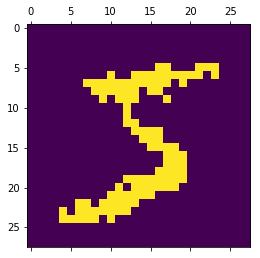

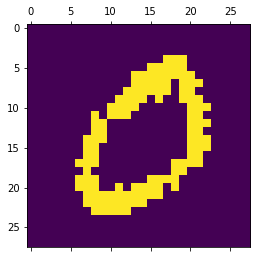

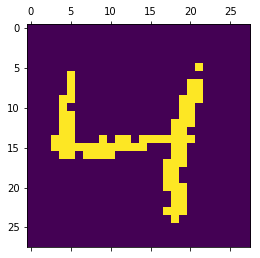

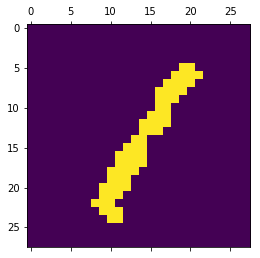

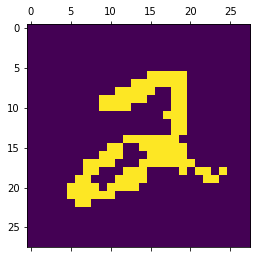

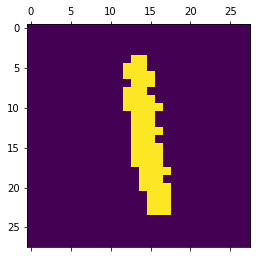

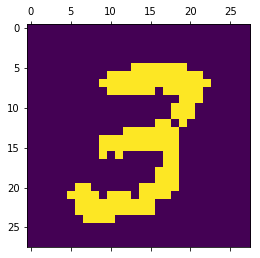

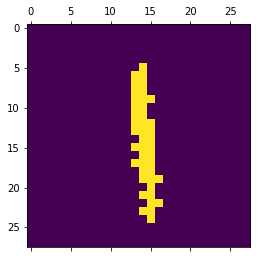

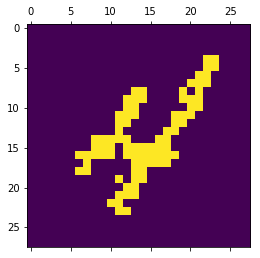

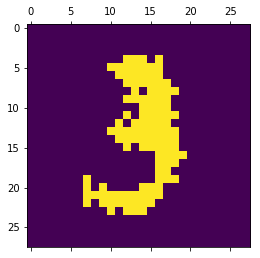

In [4]:
for i in range(10): 
    plt.matshow(train_set_unlabeled[i]['image'].squeeze())
    assert np.all(train_set_unlabeled[i]['image'].detach().numpy() <= 1)
    assert np.all(train_set_unlabeled[i]['image'].detach().numpy() >= 0)

In [5]:
batchsize = 50

train_loader_labeled = torch.utils.data.DataLoader(
                 dataset=train_set_labeled,
                 batch_size=batchsize,
                 shuffle=True)

train_loader_unlabeled = torch.utils.data.DataLoader(
                 dataset=train_set_unlabeled,
                 batch_size=batchsize,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batchsize,
                shuffle=False)


In [6]:
for batch_idx, d in enumerate(train_loader_labeled):
    labeled_data = d
    break
    
for batch_idx, d in enumerate(train_loader_unlabeled):
    unlabeled_data = d
    break
    
for batch_idx, d in enumerate(test_loader):
    test_data = d
    break


# Define VAE

In [7]:
latent_dim = 8
n_classes = 10
slen = train_set_unlabeled[0]['image'].shape[0]

In [8]:
vae, classifier = mnist_vae_lib.get_mnist_vae_and_classifier(latent_dim = latent_dim, 
                                                                n_classes = n_classes, 
                                                               slen = slen)

In [9]:
# Load results

file_base = './mnist_vae_results/ss_vae_reinforce_topk1_trial10'
classifier_file = file_base + '_classifier_final'
vae_file = file_base + '_vae_final'

vae.load_state_dict(torch.load(vae_file,
                               map_location=lambda storage, loc: storage))

classifier.load_state_dict(torch.load(classifier_file,
                               map_location=lambda storage, loc: storage))


vae.eval();
classifier.eval();

# Check losses

In [10]:
batch_losses = np.load(file_base + '_batch_losses.npy')

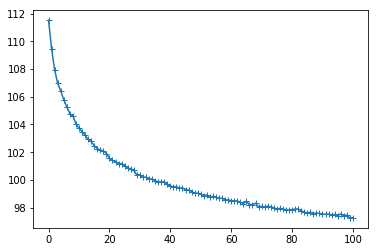

In [11]:
# plot losses
plt.plot(batch_losses, '+-')

In [12]:
train_losses = np.load(file_base + '_train_losses.npy')
test_losses = np.load(file_base + '_test_losses.npy')

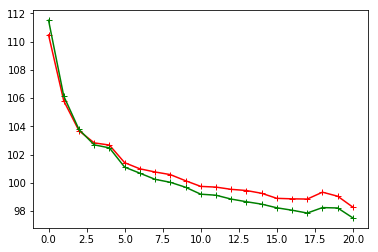

In [13]:
plt.plot(test_losses, 'r-+')
plt.plot(train_losses, 'g-+')

In [14]:
train_accuracies = np.load(file_base + '_train_accuracy.npy')
test_accuracies = np.load(file_base + '_test_accuracy.npy')

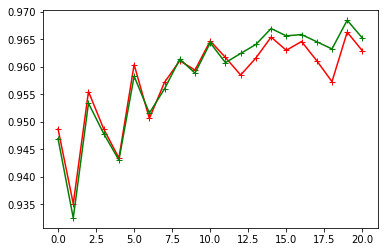

In [15]:
plt.plot(test_accuracies, 'r-+')
plt.plot(train_accuracies, 'g-+')

In [16]:
test_accuracies[-1]

0.9629

In [17]:
image = labeled_data['image']
log_q = classifier(image)
z = torch.argmax(log_q, dim = 1)

In [18]:
torch.max(torch.exp(log_q), dim = 1)

(tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.]),
 tensor([ 9,  0,  7,  9,  4,  0,  7,  2,  7,  4,  3,  5,  7,  1,
          6,  1,  3,  2,  7,  1,  5,  1,  3,  9,  9,  4,  6,  4,
          3,  5,  7,  1,  2,  8,  1,  3,  3,  7,  5,  9,  1,  4,
          1,  3,  0,  8,  5,  3,  3,  8]))

In [19]:
loss = vae_utils.get_labeled_loss(vae, image, z).mean()

In [20]:
loss

tensor(94.4614)

In [21]:
batch_losses[-1]

97.27914

# Check reconstructions

In [22]:
one_hot_z = vae_utils.get_one_hot_encoding_from_int(z, n_classes)

In [23]:
latent_means, latent_std, latent_samples, image_mean = \
    vae.forward(image, one_hot_z)

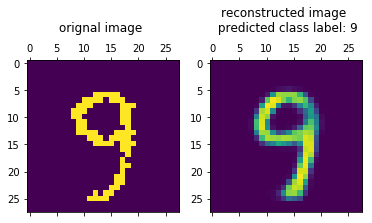

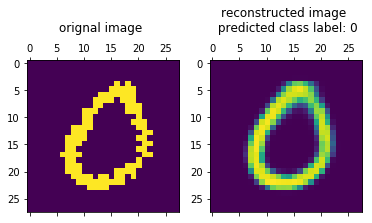

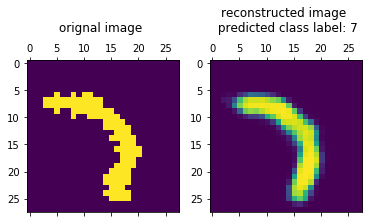

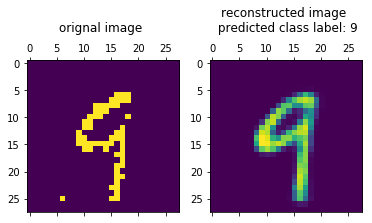

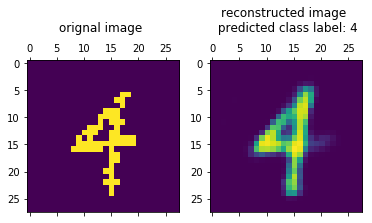

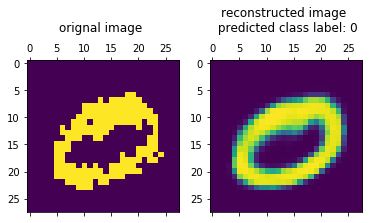

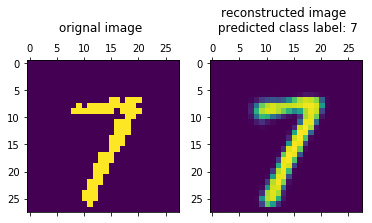

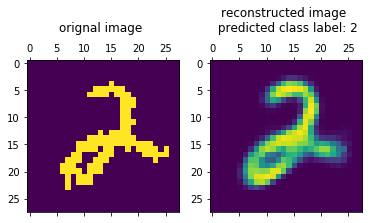

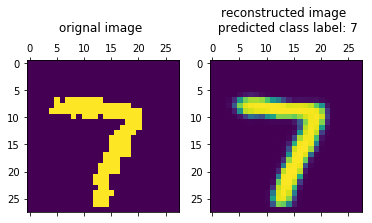

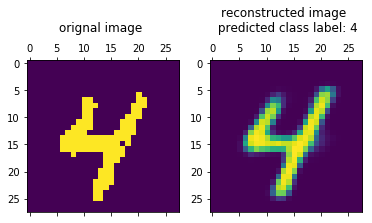

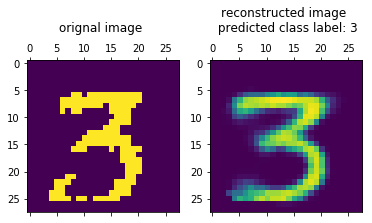

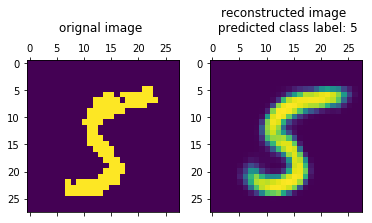

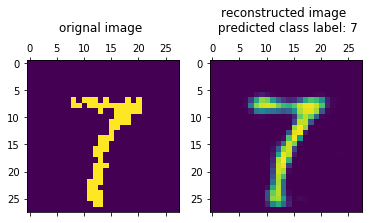

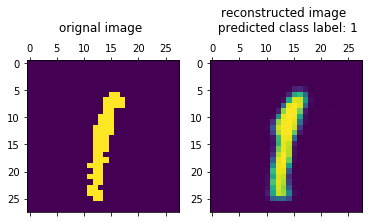

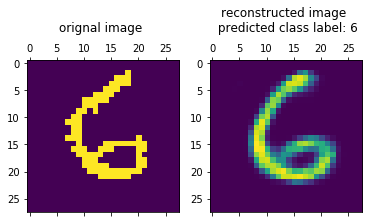

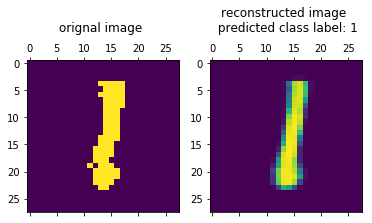

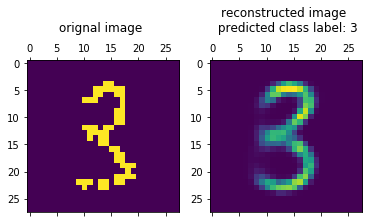

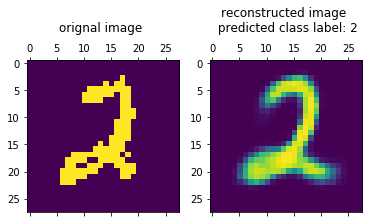

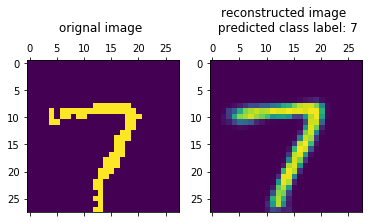

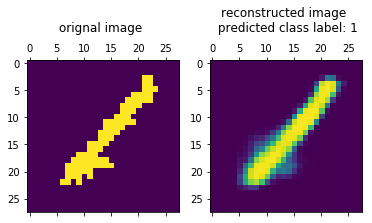

In [24]:
figsize = 6
for i in range(0, 20): 
    f, axarr = plt.subplots(1, 2, figsize=(figsize, figsize))

    axarr[0].matshow(image[i, :, :])
    axarr[1].matshow(image_mean[i, :, :].detach())
    
    axarr[0].set_title('orignal image \n')
    axarr[1].set_title('reconstructed image \n predicted class label: {}\n'.format(z[i]))

# check conditional generation

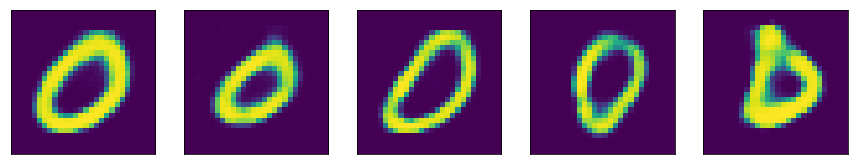

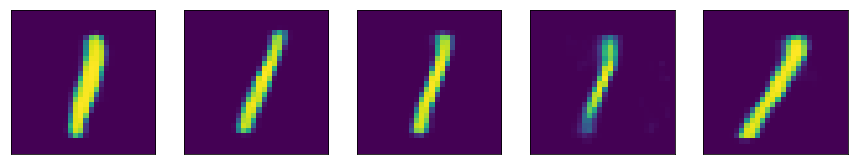

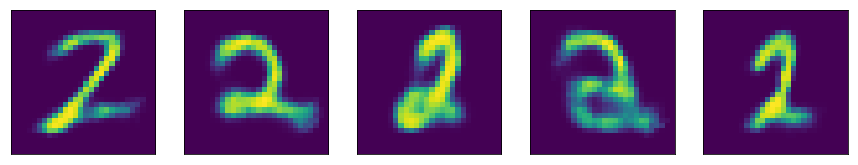

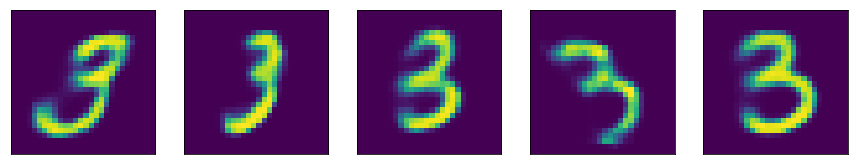

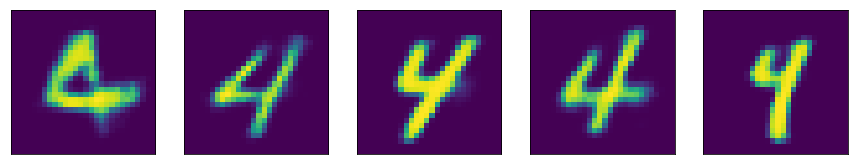

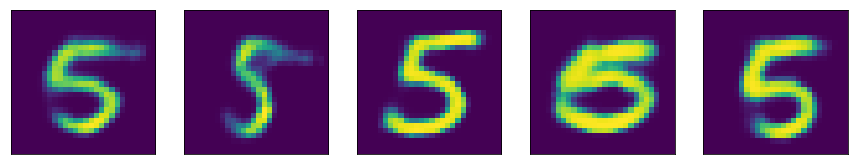

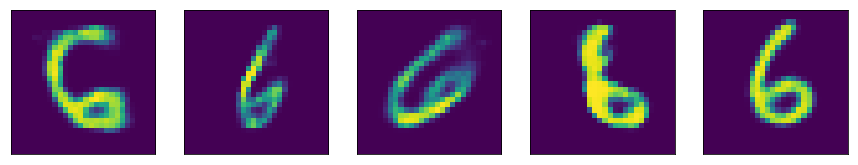

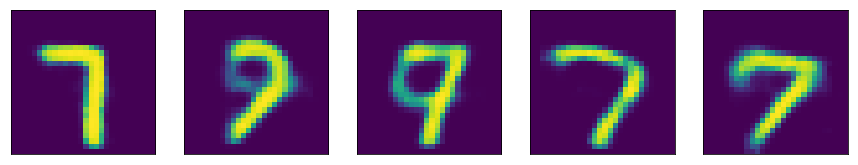

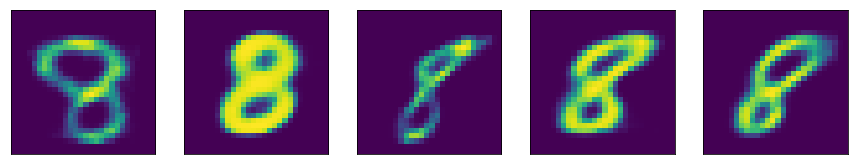

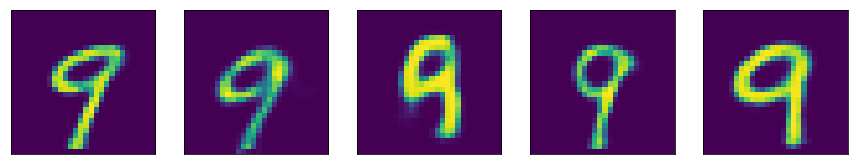

In [43]:
for i in range(10): 
    num = 5
    latent_params = torch.randn((5, latent_dim)) 

    digit = i
    one_hot_z = vae_utils.get_one_hot_encoding_from_int((torch.ones(num) * digit).type(torch.LongTensor), 
                                                        n_classes)
    recon_mean = vae.decoder(latent_params, one_hot_z)

    f, axarr = plt.subplots(1, num, figsize=(15, 15))

    for i in range(0, num): 
        axarr[i].matshow(recon_mean[i, :, :].detach())
        axarr[i].get_xaxis().set_visible(False)
        axarr[i].get_yaxis().set_visible(False)



In [35]:
topk1_batch_losses = np.load('./mnist_vae_results/ss_vae_topk1_batch_losses.npy')

In [36]:
topk10_batch_losses = np.load('./mnist_vae_results/ss_vae_topk10_batch_losses.npy')
topk0_batch_losses = np.load('./mnist_vae_results/ss_vae_reinforce_batch_losses.npy')

In [46]:
topk10_batch_losses

array([110.15876 , 107.82765 , 106.42    , 105.713356, 104.98109 ,
       104.61041 , 104.119774, 103.73078 , 103.40891 , 103.10274 ,
       102.66813 , 102.52875 , 102.312935, 102.05099 , 101.850105,
       101.70171 , 101.52382 , 101.34298 , 101.11716 , 101.060265,
       100.87179 , 100.87992 , 100.69028 , 100.49243 , 100.41905 ,
       100.33577 , 100.21161 , 100.191376, 100.03754 ,  99.92205 ,
        99.904144,  99.815605,  99.635796,  99.62611 ,  99.49087 ,
        99.5721  ,  99.47639 ,  99.37289 ,  99.300285,  99.19927 ,
        99.10331 ,  99.097084,  99.019226,  99.026436,  98.94853 ,
        98.806915,  98.83348 ,  98.820015,  98.66413 ,  98.65439 ,
        98.67229 ,  98.59206 ,  98.5037  ,  98.411934,  98.42598 ,
        98.36037 ,  98.2983  ,  98.32721 ,  98.25757 ,  98.27502 ,
        98.270996,  98.11143 ,  98.1603  ,  98.071686,  98.08183 ,
        98.08989 ,  98.05268 ,  97.984116,  97.92186 ,  97.99195 ,
        97.957344,  97.81915 ,  97.83882 ,  97.85168 ,  97.849

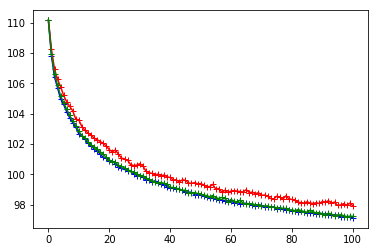

In [37]:
plt.plot(topk10_batch_losses, 'b+-')
plt.plot(topk0_batch_losses, 'r+-')
plt.plot(topk1_batch_losses, 'g+-')


In [43]:
topk1_train_accuracy = np.load('./mnist_vae_results/ss_vae_topk1_train_accuracy.npy')
topk0_train_accuracy = np.load('./mnist_vae_results/ss_vae_reinforce_train_accuracy.npy')
topk10_train_accuracy = np.load('./mnist_vae_results/ss_vae_topk10_train_accuracy.npy')

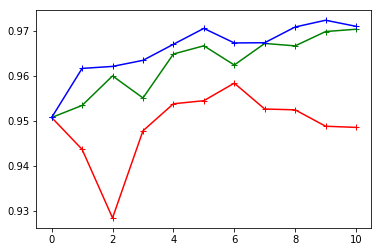

In [45]:
plt.plot(topk0_train_accuracy, 'r+-')
plt.plot(topk1_train_accuracy, 'g+-')
plt.plot(topk10_train_accuracy, 'b+-')

In [7]:
gumbel_batch_losses = np.load('./mnist_vae_results/gumbel_vae_batch_losses.npy')

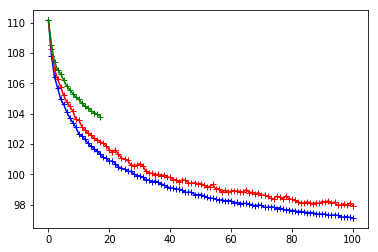

In [8]:
plt.plot(topk10_batch_losses, 'b+-')
plt.plot(topk0_batch_losses, 'r+-')
plt.plot(gumbel_batch_losses, 'g+-')
